# Netflix Stock Prediction using LSTM

This project uses the LSTM to predict the closing price of Netflix stock based on the performance of the previous 60 days

Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from sklearn.preprocessing import MinMaxScaler
plt.style.use('fivethirtyeight')

Loading the dataset

In [2]:
stock = pd.read_csv('NFLX.csv', index_col = "Date")
stock

Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-09-11  178.100006  182.470001  178.029999  181.740005  181.740005   
2017-09-12  182.550003  185.330002  180.639999  185.149994  185.149994   
2017-09-13  184.070007  184.500000  182.550003  183.639999  183.639999   
2017-09-14  183.250000  185.289993  182.070007  182.630005  182.630005   
2017-09-15  182.729996  184.929993  181.429993  182.350006  182.350006   
...                ...         ...         ...         ...         ...   
2022-09-01  220.720001  230.369995  219.470001  230.039993  230.039993   
2022-09-02  231.029999  233.880005  225.039993  226.110001  226.110001   
2022-09-06  225.589996  226.850006  214.690002  218.389999  218.389999   
2022-09-07  220.210007  229.330002  218.270004  228.960007  228.960007   
2022-09-08  224.160004  228.740005  221.300003  227.440002  227.440002   

             Volume  
Date                 
2017-09-11  5979400  
2017-09-12  6689600  
2017-09-13  4320300  
2017-09-14  4510700  
2017-09-15  5591700  
...             ...  
2022-09-01  7292900  
2022-09-02  8155600  
2022-09-06  7469000  
2022-09-07  8149300  
2022-09-08  6727700  

[1258 rows x 6 columns]

Plotting the High and Low values over the five year period

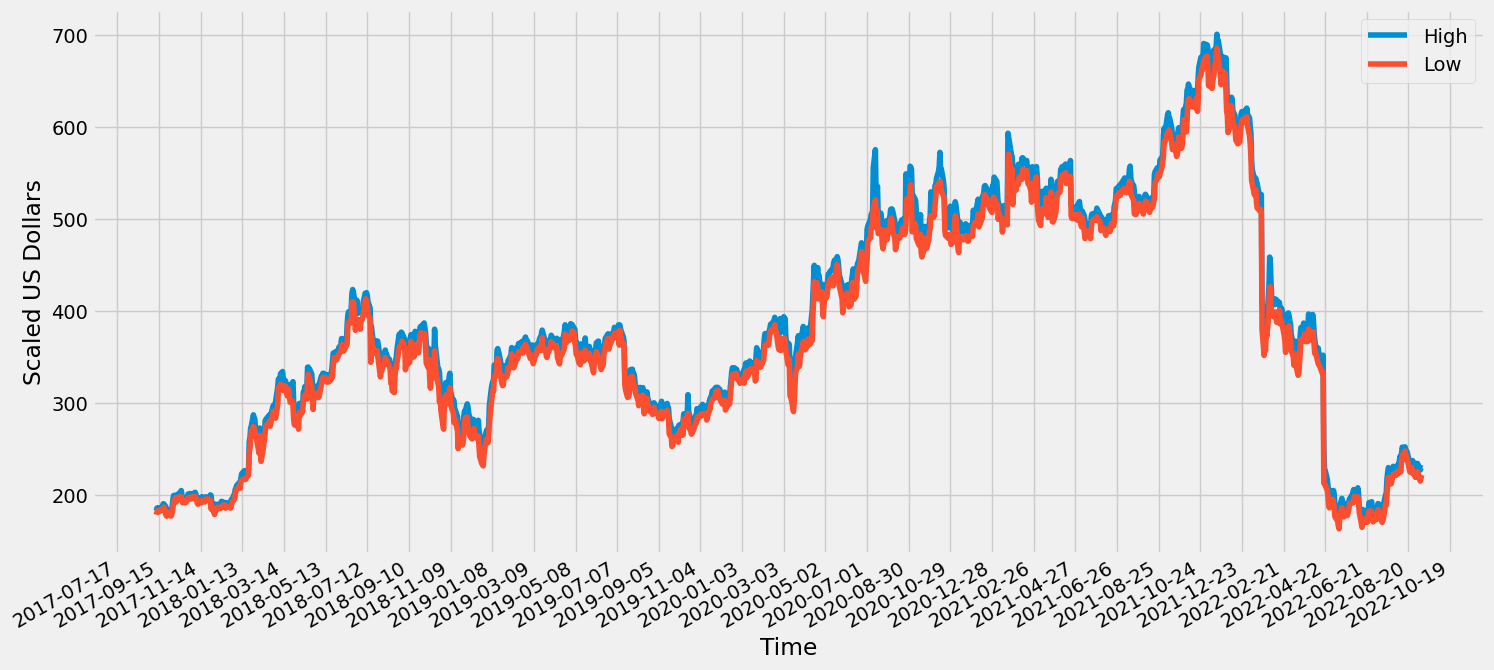

In [3]:
plt.figure(figsize = (16,8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 60))
x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in stock.index.values]
plt.plot(x_dates, stock["High"], label = "High")
plt.plot(x_dates, stock["Low"], label = "Low")
plt.xlabel("Time")
plt.ylabel("Scaled US Dollars")
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

Processing the data

In [4]:
#Getting the Close values
data = stock.filter(['Close'])
dataset = data.values

#Scaling the data
sc = MinMaxScaler(feature_range = (0,1))
scaled = sc.fit_transform(dataset)

Creating training sets

In [5]:
#Creating 80-20 test split
train_split = .8
split_index = int(np.ceil(len(dataset)*train_split))

#Creating X and y training sets
train = scaled[0:split_index, :]
x_train, y_train = [], []
for i in range(60, len(train)):
    x_train.append(train[i-60:i, 0])
    y_train.append(train[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Building and compiling the model

In [6]:
#Creating the model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False, input_shape = (x_train)))
model.add(Dense(25))
model.add(Dense(1))

#Compiling the model using MSE as the loss function
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

Fitting the model on the training data and evaluating on the test data

In [7]:
#Train the model
model.fit(x_train, y_train, batch_size = 1, epochs = 1)

#Make test sets
test = scaled[split_index - 60: , :]
x_test = []
y_test = dataset[split_index:, :]

for i in range(60, len(test)):
    x_test.append(test[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)

#Calculate RMSE
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

8/8 [==============================] - 1s 11ms/step


12.712991770842413

C:\Users\talan\AppData\Local\Temp\ipykernel_11008\3528346178.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['Predictions'] = predictions


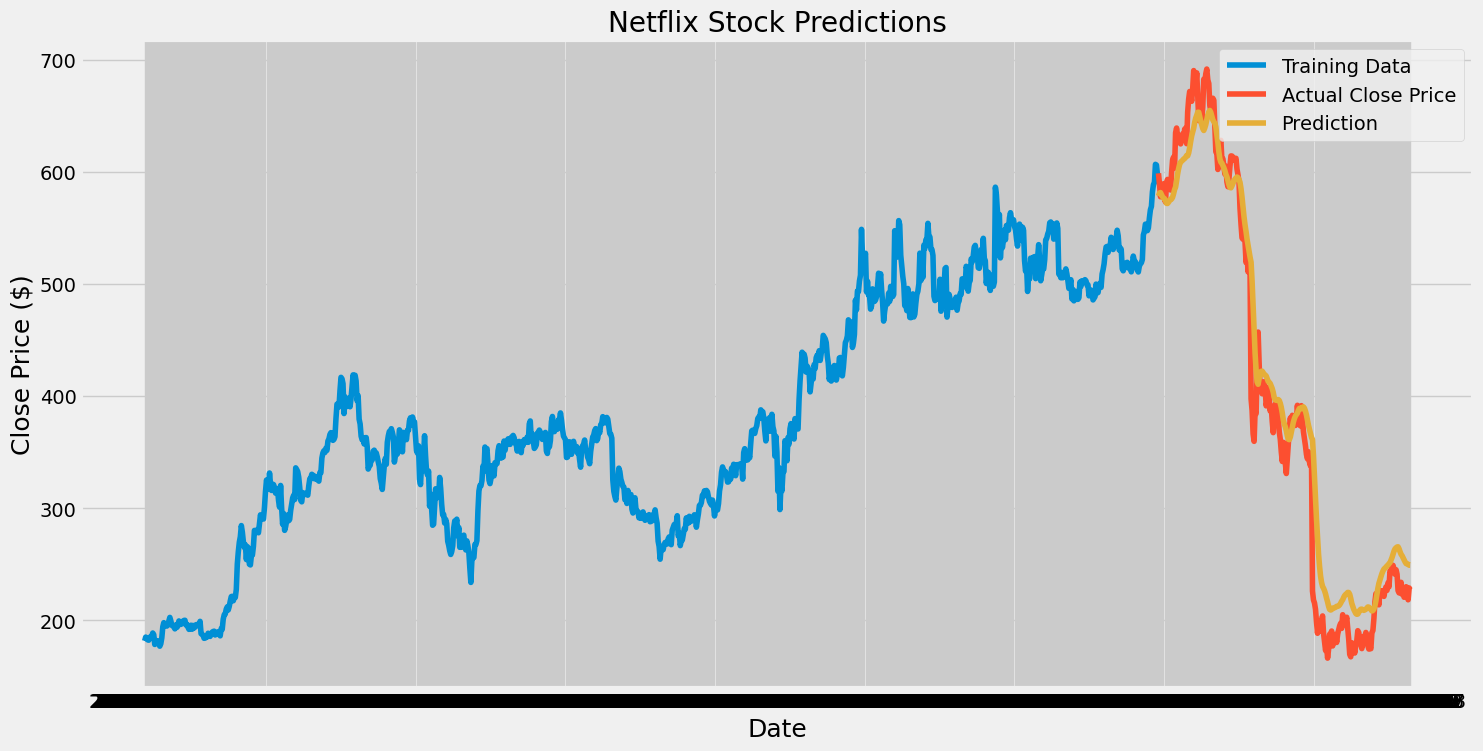

In [8]:
#Plot
training = data[:split_index]
actual = data[split_index:]
actual['Predictions'] = predictions
plt.figure(figsize = (16,8))
plt.title("Netflix Stock Predictions")
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price ($)', fontsize = 18)
plt.plot(training['Close'])
plt.plot(actual[['Close', 'Predictions']])
plt.legend(['Training Data', 'Actual Close Price', 'Prediction'], loc = 'upper right')
plt.show()

Table showing the actual prices versus the predicted prices

In [9]:
actual['Absolute differences'] = np.abs(actual['Close'] - actual['Predictions'])
actual

C:\Users\talan\AppData\Local\Temp\ipykernel_11008\2587589150.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['Absolute differences'] = np.abs(actual['Close'] - actual['Predictions'])


Close  Predictions  Absolute differences
Date                                                     
2021-09-10  598.719971   578.439880             20.280091
2021-09-13  589.289978   581.012695              8.277283
2021-09-14  577.760010   581.541626              3.781616
2021-09-15  582.869995   579.750610              3.119385
2021-09-16  586.500000   577.882629              8.617371
...                ...          ...                   ...
2022-09-01  230.039993   250.727020             20.687027
2022-09-02  226.110001   250.384735             24.274734
2022-09-06  218.389999   250.179459             31.789460
2022-09-07  228.960007   249.239929             20.279922
2022-09-08  227.440002   249.215164             21.775162

[251 rows x 3 columns]

Our LSTM model seems to predict the stock prices decently. However, there are many external factors that affect stock price, and this model alone should not solely be used to forecast future closing prices